Modelo SGDClassifier 
- LabelEncoder()
- StandardScaler()
- Variables: "OverTime", "JobLevel", "MaritalStatus", "YearsWithCurrManager","StockOptionLevel", "JobInvolvement", "JobSatisfaction", "EnvironmentSatisfaction"
- class_weight='balanced'
- GridSearchCV
- SelectKBest

In [7]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif



In [2]:
# Cargar los datos

data = pd.read_csv('../data/HR-Employee-Attrition.csv')

In [3]:
#Features & Target

features = [
    "OverTime", "JobLevel", "MaritalStatus", "YearsWithCurrManager",
    "StockOptionLevel", "JobInvolvement", "JobSatisfaction", "EnvironmentSatisfaction",
    "Age", "MonthlyIncome", "TotalWorkingYears", "BusinessTravel", "DistanceFromHome"
]
X = data[features].copy()
y = data['Attrition'].map({'Yes': 1, 'No': 0})

In [4]:
# Encoding categorical variables

cat_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le 

In [5]:
# Scaling 

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Aplicar SelectKBest para seleccionar las mejores características
selector = SelectKBest(score_func=f_classif, k=8)  
selector.fit(X, y) 
mask = selector.get_support()  
selected_features = [feature for feature, selected in zip(features, mask) if selected]  
X = selector.transform(X) 
print(f"Características seleccionadas: {selected_features}")

Características seleccionadas: ['OverTime', 'JobLevel', 'MaritalStatus', 'YearsWithCurrManager', 'StockOptionLevel', 'Age', 'MonthlyIncome', 'TotalWorkingYears']


In [9]:
# Create train and test (validation) samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1176, 8), X_test: (294, 8), y_train: (1176,), y_test: (294,)


In [10]:
# Create and train the model

model = SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42)

# Apply Grid Search to improve the selected model

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'max_iter': [1000, 2000, 5000]  
}


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Model training and evaluation
grid_search.fit(X_train, y_train)

print('Best hyperparameters: ', grid_search.best_params_, '\n')

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best hyperparameters:  {'alpha': 0.1, 'max_iter': 1000, 'penalty': 'l2'} 



In [11]:
# Visual analysis

check = pd.DataFrame({'Ground truth':y_test, 'Predictions':y_pred, 'Diff':y_test-y_pred})
check

,Ground truth,Predictions,Diff
1041,0,1,-1
184,0,0,0
1222,1,1,0
67,0,0,0
220,0,0,0
...,...,...,...
567,0,0,0
560,0,0,0
945,0,0,0
522,0,1,-1


In [12]:
#Modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

txt = f"""
Accuracy: {accuracy:.4f}
Precision: {precision:.4f}
Recall: {recall:.4f}
F1 Score: {f1:.4f}
ROC AUC Score: {roc_auc:.4f}
"""
print(txt)


Accuracy: 0.6837
Precision: 0.2188
Recall: 0.5385
F1 Score: 0.3111
ROC AUC Score: 0.6222



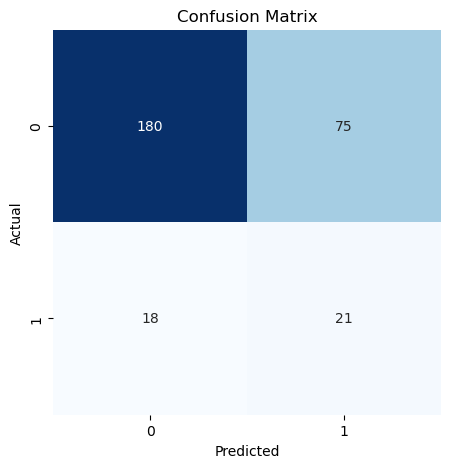

In [13]:
# Mtriz de confusión
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
